<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/BERT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import random
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from transformers import BertTokenizer, BertModel

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [184]:
len(tokenizer.vocab)

30522

In [185]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [186]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [187]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


In [0]:
def tokenize_and_cut(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [190]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 6838
Number of validation examples: 886
Number of testing examples: 3259


In [191]:
print(vars(train_data.examples[7]))

{'Tweet': [24246, 2015, 8239, 19662, 10875, 3085, 3475, 1005, 1056, 2002, 1029, 2042, 8239, 21794, 2153, 1010, 2139, 4502, 2100, 2038, 2246, 11519, 1006, 2003, 2232, 1007, 3892], 'anger': '1', 'anticipation': '0', 'disgust': '1', 'fear': '0', 'joy': '0', 'love': '0', 'optimism': '0', 'pessimism': '0', 'sadness': '0', 'surprise': '0', 'trust': '0'}


In [192]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[7])['Tweet'])

print(tokens)

['rooney', '##s', 'fucking', 'unto', '##uch', '##able', 'isn', "'", 't', 'he', '?', 'been', 'fucking', 'dreadful', 'again', ',', 'de', '##pa', '##y', 'has', 'looked', 'decent', '(', 'is', '##h', ')', 'tonight']


In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = BATCH_SIZE,
    device = device
)

# Build Vocab for Labels

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

In [195]:
torch.transpose(torch.stack([getattr(aux, label) for label in LABEL_COLS]), 0, 1)

tensor([[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1.,

# Build the Model

In [0]:
bert = BertModel.from_pretrained('bert-base-uncased')

In [0]:
class BertCNN(nn.Module):
  def __init__(self, bert, n_filters, filter_sizes, output_dim, dropout):
    super().__init__()

    self.bert = bert 

    embedding_dim = bert.config.to_dict()['hidden_size']

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    with torch.no_grad():
      embedded = self.bert(text)[0]
    
    embedded = embedded.unsqueeze(1)
    
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    
    cat = self.dropout(torch.cat(pooled, dim = 1))
    
    return self.fc(cat)

In [0]:
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 11
DROPOUT = 0.5

model = BertCNN(bert, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [199]:
model

BertCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [200]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 110,407,451 trainable parameters


In [0]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [202]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 925,211 trainable parameters


In [203]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

convs.0.weight
convs.0.bias
convs.1.weight
convs.1.bias
convs.2.weight
convs.2.bias
fc.weight
fc.bias


# Train the Model

In [0]:
import torch.optim as optim

In [0]:
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
def roc_auc(preds, y):
  global var_y
  global var_preds 
  var_y = y
  var_preds = preds
  acc = roc_auc_score(y, preds)
  return acc

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()
    
    predictions = model(batch.Tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item() 
  
  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  preds_list = []
  labels_list = []
  epoch_acc = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions = model(batch.Tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [211]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-cnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.427 | Train Acc: 67.58%
	 Val. Loss: 0.354 |  Val. Acc: 81.59%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.360 | Train Acc: 79.36%
	 Val. Loss: 0.342 |  Val. Acc: 83.30%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.337 | Train Acc: 82.41%
	 Val. Loss: 0.333 |  Val. Acc: 83.79%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.322 | Train Acc: 84.24%
	 Val. Loss: 0.326 |  Val. Acc: 84.32%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.312 | Train Acc: 85.15%
	 Val. Loss: 0.320 |  Val. Acc: 84.46%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.301 | Train Acc: 86.67%
	 Val. Loss: 0.326 |  Val. Acc: 84.68%
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.294 | Train Acc: 87.38%
	 Val. Loss: 0.322 |  Val. Acc: 84.58%
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.286 | Train Acc: 88.16%
	 Val. Loss: 0.328 |  Val. Acc: 84.65%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.276 | Train Acc: 89.12%
	 Val. Loss: 0.325 |  Val. Acc: 84.54%
Epoch: 10 | Epoch Time: 0m 8

In [0]:
import matplotlib.pyplot as plt

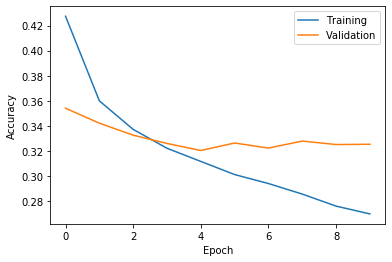

In [213]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

In [214]:
model.load_state_dict(torch.load('bert-cnn-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.316 | Test Acc: 83.90%


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  #preds += [torch.sigmoid(predictions).detach().cpu().numpy()]
  return preds

In [216]:
LABEL_COLS

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [217]:
preds = predict_emotion(model, tokenizer, "Do you think humans have the sense for recognizing impending doom?")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.10812739282846451
ANTICIPATION: 0.6953992247581482
DISGUST: 0.28122904896736145
FEAR: 0.3449912965297699
JOY: 0.02500464953482151
LOVE: 0.0022310586646199226
OPTIMISM: 0.1092003658413887
PESSIMISM: 0.2632802128791809
SADNESS: 0.1401190161705017
SURPRISE: 0.05643027648329735
TRUST: 0.01979478821158409
